<h2>Filtros Espaciais com scipy.ndimage e scikit-image</h2>
Objetivos
Aprender a:

Aplicar filtros a imagens coloridas (RGB) e imagens níveis de cinza
Suavizar (borrar) imagens com vários filtros passa-baixa
Descobrir e aplicar vários filtros passa-alta
Aplicar filtros customizados a imagens (convolução 2D)
Adaptando filtros de níveis de cinza a imagens RGB
Muitos filtros são projetados para trabalharem com imagens em níveis de cinza, mas não com imagens coloridas. Para simplificar o processo de criar funções que possam ser adaptadas a imagens RGB, o scikit-image provê um decorator adapt-rgb.

Este decorator provê duas maneiras padrão de utilização:

each_channel - passa cada canal RGB ao filtro, um por um, e depois junta o resultado de volta em uma imagemm RGB.

hsv_value - converte a imagen RGB para HSV e passa o canal valor para o filtro. O resultado filtrado é inserido de volta na imagem HSV e convertido de volta para RGB.

Veja abaixo, uma demonstração do uso do adapt_rgb em alguns filtros dle níveis de cinza:


In [ ]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

import skimage
skimage.__version__

from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

from scipy.ndimage import generic_filter, correlate
from skimage import io
import numpy as np
import functools

%matplotlib inline

Text(0.5, 1.0, 'Filtro Sobel calculado\n sobre o (V)alor da imagem (HSV) convertida')

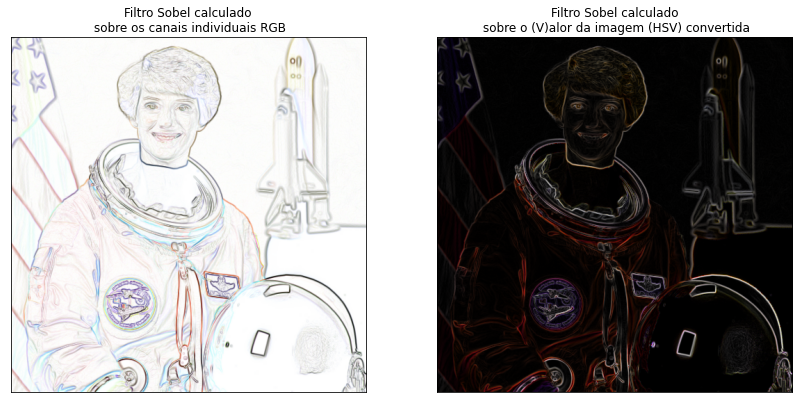

In [ ]:
image = data.astronaut()

fig = plt.figure(figsize=(14, 7))
ax_each = fig.add_subplot(121, adjustable='box')
ax_hsv = fig.add_subplot(122, sharex=ax_each, sharey=ax_each,
                         adjustable='box')

# Usamos aqui 1 - sobel_each(image)
# mas isso nao funcionara se image nao eh normalizada
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Filtro Sobel calculado\n sobre os canais individuais RGB")

# Usamos 1 - sobel_hsv(image) mas nao funcionara se a imagem nao for normalizada
ax_hsv.imshow(rescale_intensity(sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Filtro Sobel calculado\n sobre o (V)alor da imagem (HSV) convertida")

Text(0.5, 1.0, 'Imagem RGB original')

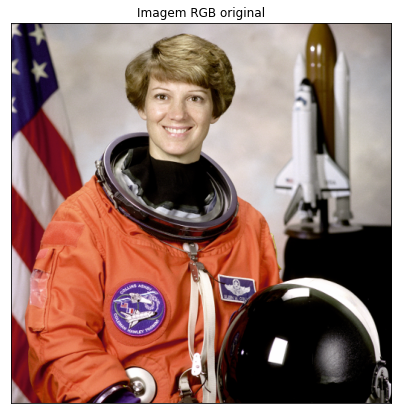

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.subplot(111), plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Imagem RGB original")

<h2>Convertendo para Niveis de Cinza antes de aplicar o filtro</h2>
No exemplo abaixo, a imagem colorida (RGB) original é primeiramente convertida para níveis de cinza e depois o filtro é aplicado.

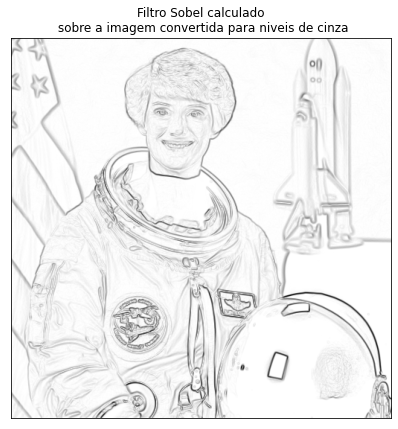

In [ ]:
from skimage.color import rgb2gray

gray_image = rgb2gray(image)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, sharex=ax_each, sharey=ax_each,
                     adjustable='box')

# Usamos 1 - sobel(gray_image)
# Mas nao funcionaria se a imagem nao estivesse normalizada
ax.imshow(rescale_intensity(1 - filters.sobel(gray_image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Filtro Sobel calculado\n sobre a imagem convertida para niveis de cinza")

plt.show()

<h2>Agora que já sabemos como aplicar filtros em imagens coloridas, podemos passar para a construção dos kernels e sua exploração.</h2>

Convolução 2D (Filtros de imagens)
Assim como sinais de uma dimensão, as imagens também podem ser filtradas com vários filtros passa-baixa (low-pass filters -- LPF), filtros passa-alta (high-pass filters -- HPF), etc. Um filtro LPF ajuda na remoção de ruído, ou no borramento da imagem. Um filtro HPF ajuda na localização de bordas em uma imagem.

O scipy.ndimage provê funções para fazer a convolução de um kernel com uma imagem. Como um exemplo, vamos fazer um filtro de média em uma imagem. Um kernel de média 5x5 pode ser definido como:

<h2>Definindo nossa função genérica</h2>
Vamos definir uma função genérica func que receberá os valores selecionados no generic_filter e também os pesos de cada posição; cada valor será multiplicado pelo respectivo peso e o resultado somado.

O valor resultante de cada pixel após a aplicação do filtro pode ser negativo ou maior do que 255. Se isto acontece, temos duas abordagens:

truncá-los, de modo que valores menores do que 0 se tornem 0 e valores maiores do que 255 fiquem com 255.
para valores negativos, também podemos pegar os valores absolutos ao invés de truncar.
Esta função genérica vai fazer o truncamento, mas é fácil modificá-la para pegar o valor absoluto dos negativos.

In [ ]:
def fnc(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return min(max((buffer * weights).sum(),0),255)
#    return (buffer * weights).sum()

# Um array de dimensao 5x5
kernel = np.ones((3,3),np.uint8)

# Uma máscara de 9 elementos
ws = [-1,-1,-1,-1,8,-1,-1,-1,-1,]
ws = [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,]
# uma imagem 8x8 com 1's
imgd = np.ones((8,8),np.int8)
# acertando os valores
imgd[0,:] = [10, 9, 8, 25, 11, 12, 12, 11]
#img[0,7] = 0
imgd[1,:] = [9, 8, 11, 26, 11, 10, 11, 11]
imgd[2,:] = [11, 12, 9, 25, 12, 10, 11, 9]
imgd[3,:] = [10, 12, 11, 27, 12, 11, 10, 11]
imgd[4,:] = [9,  7,  8,  27,  8,  9,  9,  8]
imgd[5,:] = [11, 11, 10, 24, 12, 10, 11, 12]
imgd[6,:] = [9,  9,  8,  28,  9,  9,  9,  8]
imgd[7,:] = [9,  8,  9,  26,  8,  9,  9,  9]


# esta função 
def fncnaq(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return (buffer * weights).sum()

def fncabs(buffer,weights):
    return min(abs((buffer * weights).sum()),255)

imgd

array([[10,  9,  8, 25, 11, 12, 12, 11],
       [ 9,  8, 11, 26, 11, 10, 11, 11],
       [11, 12,  9, 25, 12, 10, 11,  9],
       [10, 12, 11, 27, 12, 11, 10, 11],
       [ 9,  7,  8, 27,  8,  9,  9,  8],
       [11, 11, 10, 24, 12, 10, 11, 12],
       [ 9,  9,  8, 28,  9,  9,  9,  8],
       [ 9,  8,  9, 26,  8,  9,  9,  9]], dtype=int8)

In [ ]:
?np.histogram

In [ ]:
unicos = np.unique(imgd)
unicos
#novobins = np.append(unicos, unicos[-1]+1)

array([ 7,  8,  9, 10, 11, 12, 24, 25, 26, 27, 28], dtype=int8)

In [ ]:
hist = np.histogram(imgd,bins=np.append(unicos, unicos[-1]+1))
hist

(array([ 1,  9, 17,  7, 14,  8,  1,  2,  2,  2,  1]),
 array([ 7,  8,  9, 10, 11, 12, 24, 25, 26, 27, 28, 29]))

In [ ]:
MN = imgd.shape[1]*imgd.shape[0]
hist[0]/MN

array([0.015625, 0.140625, 0.265625, 0.109375, 0.21875 , 0.125   ,
       0.015625, 0.03125 , 0.03125 , 0.03125 , 0.015625])

In [ ]:
generic_filter(imgd,function=fnc,footprint=kernel,extra_arguments=(ws,))

array([[ 9,  9, 14, 15, 15, 11, 11, 11],
       [ 9,  9, 14, 15, 15, 11, 10, 10],
       [10, 10, 15, 15, 16, 10, 10, 10],
       [10,  9, 15, 15, 15, 10,  9,  9],
       [ 9,  9, 15, 15, 15, 10, 10, 10],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 8,  8, 14, 14, 14,  8,  8,  8]], dtype=int8)

In [ ]:
generic_filter(imgd,function=fncnaq,footprint=kernel,extra_arguments=(ws,))

array([[ 9,  9, 14, 15, 15, 11, 11, 11],
       [ 9,  9, 14, 15, 15, 11, 10, 10],
       [10, 10, 15, 15, 16, 10, 10, 10],
       [10,  9, 15, 15, 15, 10,  9,  9],
       [ 9,  9, 15, 15, 15, 10, 10, 10],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 8,  8, 14, 14, 14,  8,  8,  8]], dtype=int8)

In [ ]:
generic_filter(imgd,function=fncabs,footprint=kernel,extra_arguments=(ws,))

array([[ 9,  9, 14, 15, 15, 11, 11, 11],
       [ 9,  9, 14, 15, 15, 11, 10, 10],
       [10, 10, 15, 15, 16, 10, 10, 10],
       [10,  9, 15, 15, 15, 10,  9,  9],
       [ 9,  9, 15, 15, 15, 10, 10, 10],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 9,  9, 14, 14, 15,  9,  9,  9],
       [ 8,  8, 14, 14, 14,  8,  8,  8]], dtype=int8)

In [ ]:
# Um array de 1's, de dimensao 5x5
kernel = np.ones((3,3),np.uint8)

# Um vetor de 25 elementos 1's
ws = [1 for x in range(0,9)]

# Nossa imagem de testes - colorida
imagem_color = image #io.imread('/home/mario/docs/cursos/pdivc/images/opencv_logo.png')
print("Imagem colorida original - shape")
print(imagem_color.shape)

img = rgb2gray(imagem_color) # transformando para níveis de cinza
print("Imagem níveis de cinza - shape")
print(img.shape)

Imagem colorida original - shape
(512, 512, 3)
Imagem níveis de cinza - shape
(512, 512)


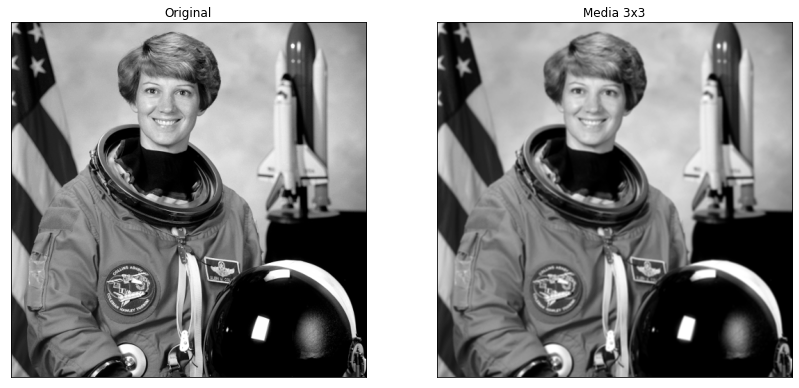

In [ ]:
fig = plt.figure(figsize=(14, 7))
dst = generic_filter(img,function=fnc,footprint=kernel,extra_arguments=(ws,))
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Media 3x3')

plt.xticks([]), plt.yticks([])
plt.show()

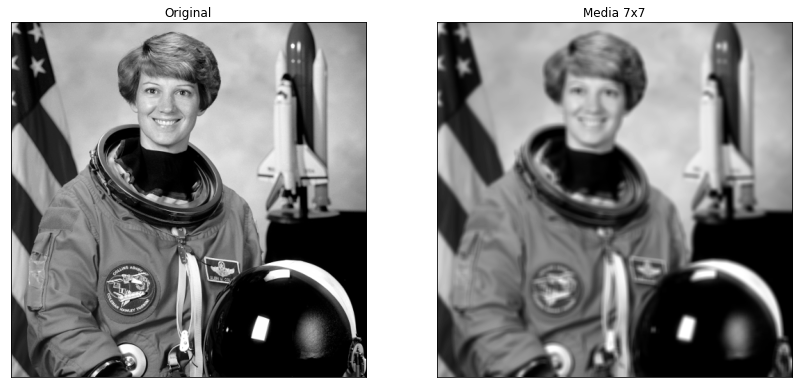

In [ ]:
# Um array de 1's, de dimensao 7x7
kernel = np.ones((7,7),np.uint8)

# Um vetor de 25 elementos 1's
ws = [1 for x in range(0,49)]

fig = plt.figure(figsize=(14, 7))
dst = generic_filter(img,function=fnc,footprint=kernel,extra_arguments=(ws,))
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Media 7x7')

plt.xticks([]), plt.yticks([])
plt.show()

<h2>Mais exemplos</h2>
Utilizando uma função direta do NumPy (median).

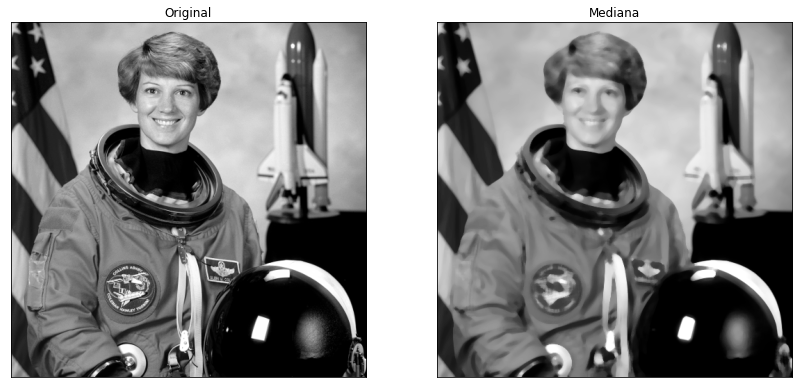

In [ ]:
fig = plt.figure(figsize=(14, 7))
dst = generic_filter(img,function=np.median,footprint=kernel)
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Mediana')

plt.xticks([]), plt.yticks([])
plt.show()

<h2>Borramento de Imagens (Suavização)</h2>
O borramento de imagens é conseguido através a convolução da imagem com um kernel de filtro passa-baixa. É útil para remover ruído. Na verdade, ele remove o conteúdo de alta frequência (p.explo., ruídos, bordas) da imagem resultando nas bordas sendo borradas quando este filtro é aplicado. (Existem algumas técnicas de borramento que não borram (suavizam) as bordas).

No scikit-image e no scipy-ndimage temos algumas opções de filtros de suavização, dentre eles:

laplace
gaussian
sobel
roberts
scharr
etc
Além destes filtros "prontos", também podemos utilizar a funcionalidade descrita anteriormente para aplicar um kernel genérico a uma imagem utilizando a função generic_filter.

Dentre os filtros de suavização mais conhecidos, estão:

1. Média (averaging)
Isto é feito através da convolução da imagem com um filtro quadrado normalizado. Ele simplesmente pega a média de todos os pixels sob a área do kernel e substitui o elemento central com esta média. Nos exemplos anteriores (acima) aprendemos como aplicar um kernel genérico a uma imagem. Um filtro quadrado 3x3 normalizado seria mais ou menos como:

In [ ]:
def media(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return (buffer * weights).sum()/sum(weights)

# Um array de 1's, de dimensao 5x5
kernel = np.ones((5,5),np.uint8)

# Um vetor de 25 elementos 1's
ws = [1 for x in range(0,25)]

from skimage.color import rgb2gray

# Nossa imagem de testes - colorida
imagem_color = image #io.imread('/home/mario/docs/cursos/pdivc/images/opencv_logo.png')
print("Imagem colorida original - shape")
print(imagem_color.shape)

img = rgb2gray(imagem_color) # transformando para níveis de cinza
print("Imagem níveis de cinza - shape")
print(img.shape)

Imagem colorida original - shape
(512, 512, 3)
Imagem níveis de cinza - shape
(512, 512)


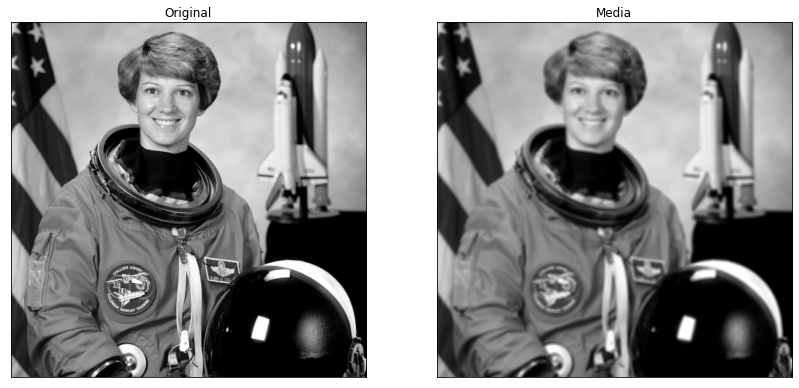

In [ ]:
# aplicando o filtro de média

fig = plt.figure(figsize=(14, 7))
dst = generic_filter(img,function=media,footprint=kernel,extra_arguments=(ws,))
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Media')

plt.xticks([]), plt.yticks([])
plt.show()

<h2>2. Filtro Gaussiano</h2>
Nesta abordagem, ao invés de um filtro quadrado consistindo de coeficientes iguais, um kernel Gaussiano é utilizado. Isto é feito com a função skimage.filters.gaussian.

O protótipo da função filters.gaussian é:

skimage.filters.gaussian(image, sigma, output=None, mode='nearest', cval=0, multichannel=None)

Precisamos fornecer image -- a imagem de entrada; sigma -- desvio padrão do kernel gaussiano (escalar ou lista); output -- um array onde guardar o resultado; mode -- {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, o tipo de tratamento das bordas; cval -- valor a ser utilizado nas bordas se mode == constant; e multichannel -- booleano, se o último eixo da imagem deve ser considerado como multicanal.

A filtragem Gaussiana é muito efetiva na remoção de ruído Gaussiano de uma imagem.

Podemos fazer uma filtragem Gaussiana de uma imagem multicanal (colorida), utilizando a seguinte chamada:

filtered_img = gaussian(image, sigma=1, multichannel=True)

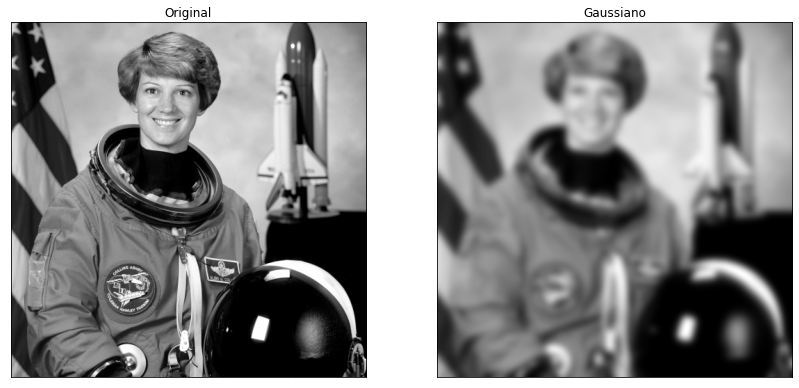

In [ ]:
# aplicando o filtro gaussiano
from skimage.filters import gaussian

fig = plt.figure(figsize=(14, 7))
dst = gaussian(img,sigma=5,multichannel=False)
plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Gaussiano')

plt.xticks([]), plt.yticks([])
plt.show()

<h2>3. Filtro de Mediana</h2>
Aqui, a função skimage.filters.rank.median() calcula a mediana de todos os pixels sob a janela do kernel e o pixel central é substituido com este valor mediano. Este filtro é muito efetivo para a remoção do ruído sal e pimenta (salt-and-pepper). Uma observação interessante é que, nos filtros quadrados e Gaussiano, o valro filtrado para o elemento central pode ser um valor que não existe na imagem original. Contudo este não é o caso do filtro de mediana, já que o elementro central sempre é substituido por algum valor de pixel da imagem. Isto reduz efetivamenteo ruído. O tamanho do kernel deve ser um inteiro ímpar positivo.

Nesta demonstração, nós adicionamos 50% de ruído a nossa imagem original e usamos um filtro de mediana. Veja o resultado:

median = cv2.medianBlur(img,5)

O código abaixo (StackOverflow http://stackoverflow.com/a/30609854/1247542 ) apresenta uma função para adicionar ruído do tipo Sal e Pimenta em uma imagem.

<h2>4. Filtragem bilateral</h2>
Como vimos acima, os filtros apresentados tendem a borrar as bordas. Este não é o caso do Filtro Bilateral, que foi definido para, e é altamente efetivo, a redução de ruído enquanto preserva as bordas. Mas esta operação é lenta comparada com outros filtros.

Já vimos que um filtro Gaussiano toma a vizinhança ao redor de um pixel e encontra sua média ponderada Gaussiana. Este filtro Gaussiano é uma função do espaço somente, isto é, pixels vizinhos são considerados enquanto se faz a filtragem. Ele não considera se um pixel tem praticamente a mesma intensidade e não considera se um pixel está ou não em uma borda. O efeito resultante é que filtros Gaussianos tendem a borrar as bordas, o que é indesejável.

O filtro bilateral também utiliza um filtro Gaussinao no domínio do espaço, mas ele também utiliza mais um componente de filtro (multiplicativo) Gaussiano que é uma função das diferenças das intensidades dos pixels. A função Gaussiana do espaço garante que somente pixels que são "vizinhos espaciais" sejam considerados, enquanto o componente Gaussiano aplicado no domínio da intensidade (uma função Gaussiana da diferença das intensidades) garante que somente aqueles pixels com intensidades similares aos daquele da região central ("vizinhos de intensidade") sejam incluídos para se calcular o valor de intensidade borrado. Como resultado, este método preserva as bordas, já que para pixels que estão próximos às bordas, os pixels vizinhos colocados do outro lado da borda, e portanto que tem maiores variações de intensidade quando comparado com o pixel central, não serão incluídos no borramento.

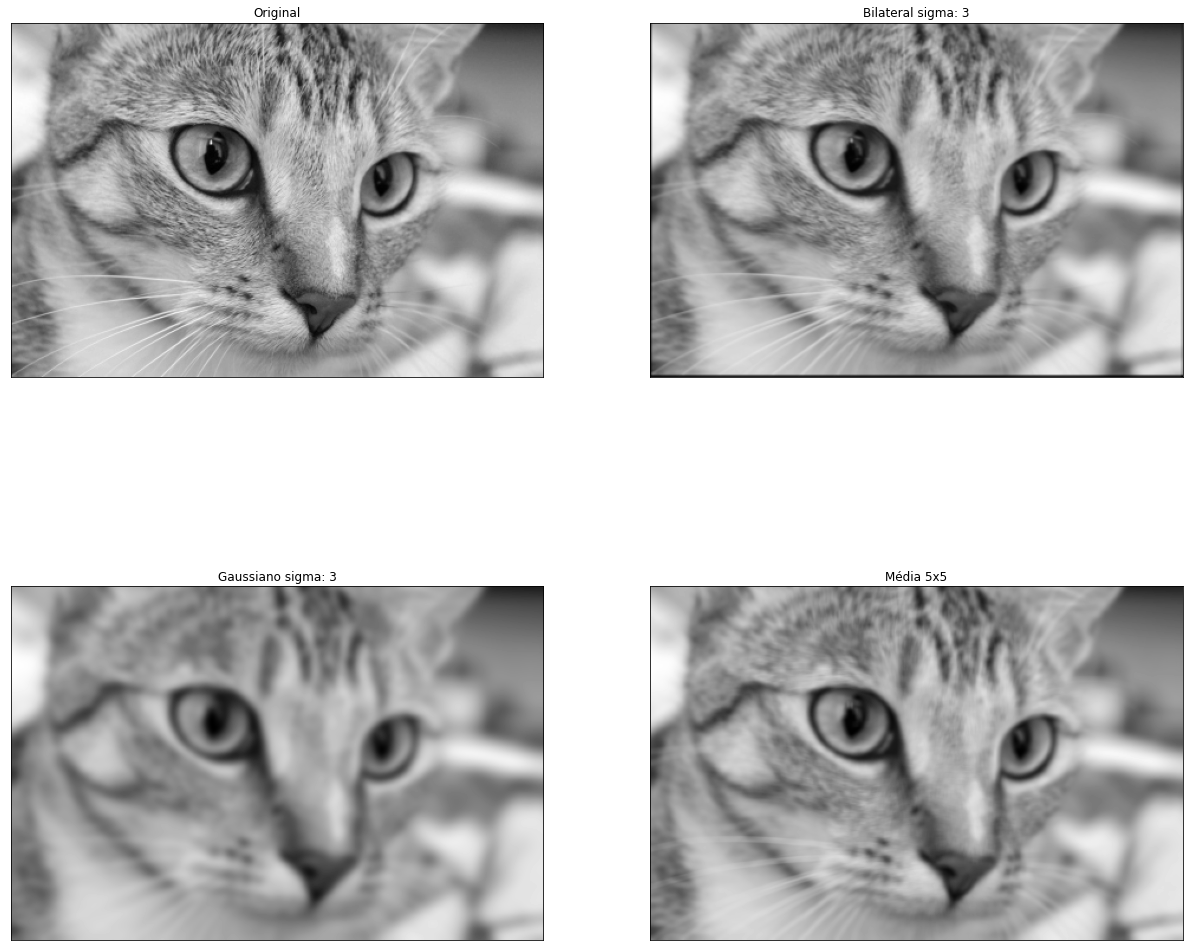

In [ ]:
from  skimage.restoration import denoise_bilateral

imagem_color = data.chelsea() #io.imread('/home/mario/docs/cursos/pdivc/images/cat-face-furry-striped.jpg')

# img_rgb = data.chelsea()
    
img = rgb2gray(imagem_color)

sigma = 3
fig = plt.figure(figsize=(21, 19))
dst = denoise_bilateral(img,win_size=5,sigma_color=sigma,multichannel=False)
dst_g = gaussian(img,sigma=sigma,multichannel=False)
dst_m = generic_filter(img,function=media,footprint=kernel,extra_arguments=(ws,))

plt.subplot(221),plt.imshow(img,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(dst,cmap='gray'),plt.title('Bilateral sigma: %s' % (sigma))
plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(dst_g,cmap='gray'),plt.title('Gaussiano sigma: %s' % (sigma))
plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(dst_m,cmap='gray'),plt.title('Média 5x5')
plt.xticks([]), plt.yticks([])


plt.show()

<h2>Exercícios -- Suavização</h2>
Pegue uma imagem, adicione ruído Gaussiano e ruído sal e pimenta, e compare os efeitos do borramento (suavização) via filtros quadrado, Gaussiano e mediano para ambas as imagens conforme você muda o nível de ruído.

Pegue uma imagem com detalhes finos (como a do gato e seu bigode, acima), adicione ruído Gaussiano e ruído sal e pimenta e compare os efeitos do borramento (suavização) via filtragem bilateral, gaussiana e de média (com kernel). Experimente diversos valores de sigma e tamanho do kernel para ver os resultados.

Submeta via Moodle:

o notebook com todas as células de execução abertas, contendo suas funções para adicionar os ruídos, para realizar as filtragens nas diversas imagens.
um relatório explicando as experiências e suas observações sobre cada filtro.

<h2>1. Filtros Derivativos Sobel e Scharr</h2>
Os operadores de Sobel são uma junção de suavização Gaussiana com operação de diferenciação, de modo que são mais resistentes a ruído. É possível fazer a filtragem especificando a direção das derivadas a serem tomadas -- vertical ou horizontal (chamando as funções especializadas sobel_h/scharr_h (horizontal) e sobel_v/scharr_v (vertical). O kernel utilizado em ambas funções é 3x3. Veja na documentação os valores dos kernels.

<h2>2. Filtros Derivativos Laplacianos</h2>
Eles calculam o Laplaciano da imagem, dado pela relação  Δsrc=δ2srcδx2+δ2srcδy2 .

Código
O código abaixo mostra todos os operadores em um único diagrama. Todos os kernels são de tamanho 5x5. A profundidade da imagem de saída é passada como -1 para pegar os resultados como tipo np.uint8.

(400, 600)


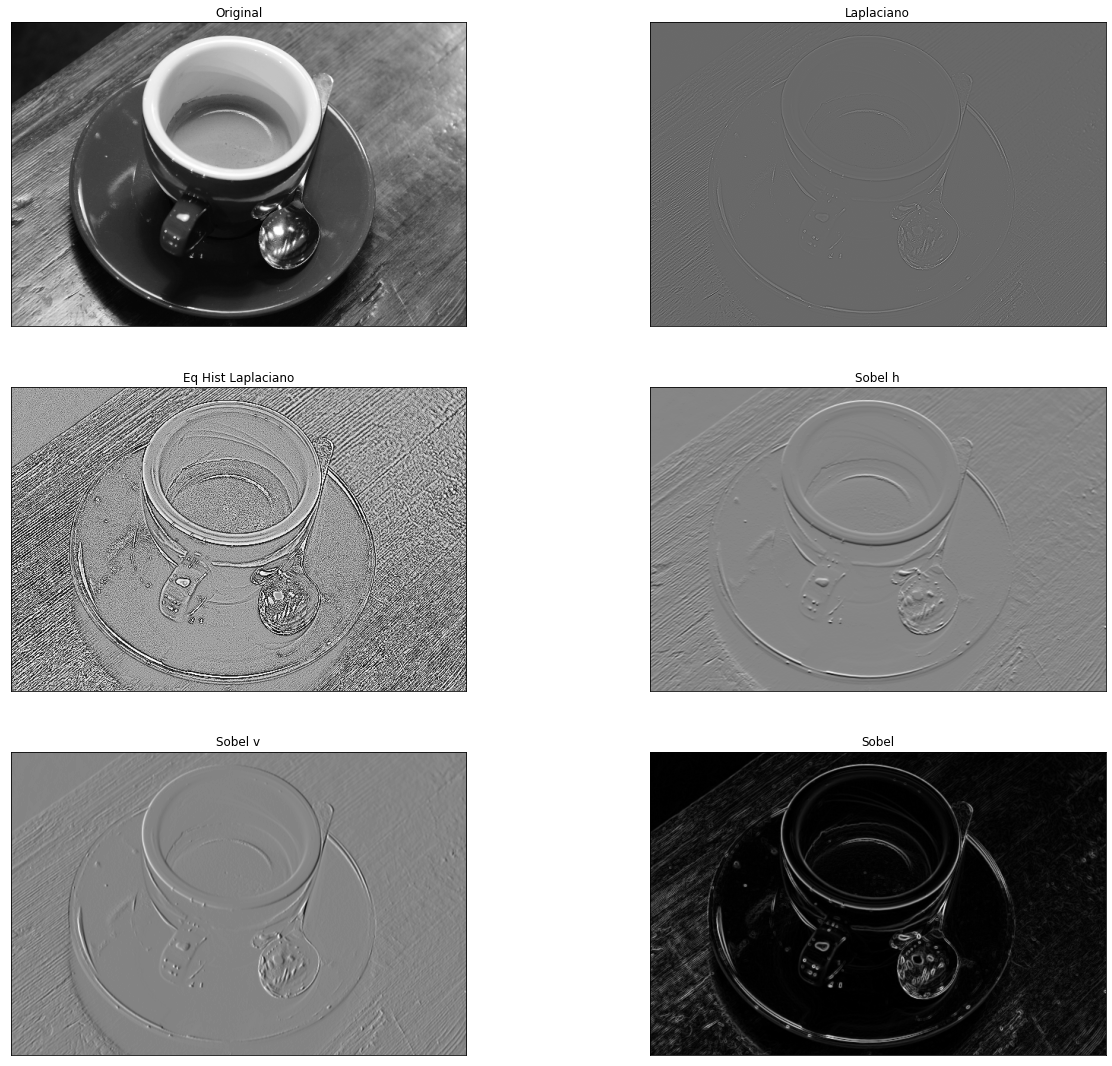

In [ ]:
from skimage.filters import laplace, sobel_h, sobel_v, sobel
from skimage.exposure import equalize_hist, rescale_intensity

imagem_color = data.coffee() #io.imread('dave.jpg')
img = rgb2gray(imagem_color)
print(img.shape)

#limiar = 160
#img[img > limiar] = 255
#img[img <= limiar] = 0

laplacian = laplace(img,ksize=3)
img_sobel_h = sobel_h(img)
img_sobel_v = sobel_v(img)
img_sobel = sobel(img)

fig = plt.figure(figsize=(21, 19))
plt.subplot(3,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplaciano'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(equalize_hist(laplacian),cmap = 'gray')
plt.title('Eq Hist Laplaciano'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(img_sobel_h,cmap = 'gray')
plt.title('Sobel h'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,5),plt.imshow(img_sobel_v,cmap = 'gray')
plt.title('Sobel v'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,6),plt.imshow(img_sobel,cmap = 'gray')
plt.title('Sobel'), 
plt.xticks([]), plt.yticks([])

plt.show()

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

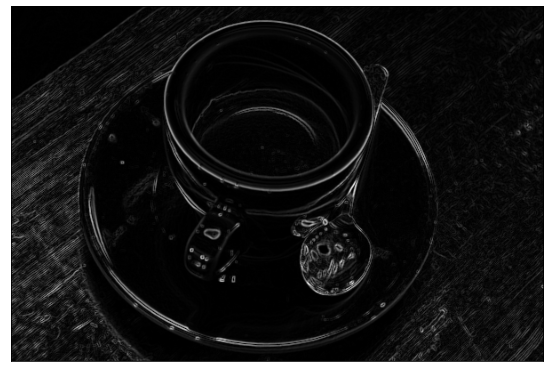

In [ ]:
fig = plt.figure(figsize=(21, 19))
plt.subplot(1,2,1),plt.imshow(abs(img_sobel_h)+abs(img_sobel_v),cmap='gray')
plt.yticks([]),plt.xticks([])

<h2>Exercício Gradientes 1</h2>
Pesquise as melhores alternativas para a visualização dos filtros direcionais sobel_h e sobel_v mostrando imagens binárias.

Exercício Gradientes 2
Utilize outras imagens (da Web ou do scikit ) e aplique os filtros derivativos (kernel) manualmente (com a função generic_filter() ) para poder experimentar diversos valores de kernel.

(427, 640)


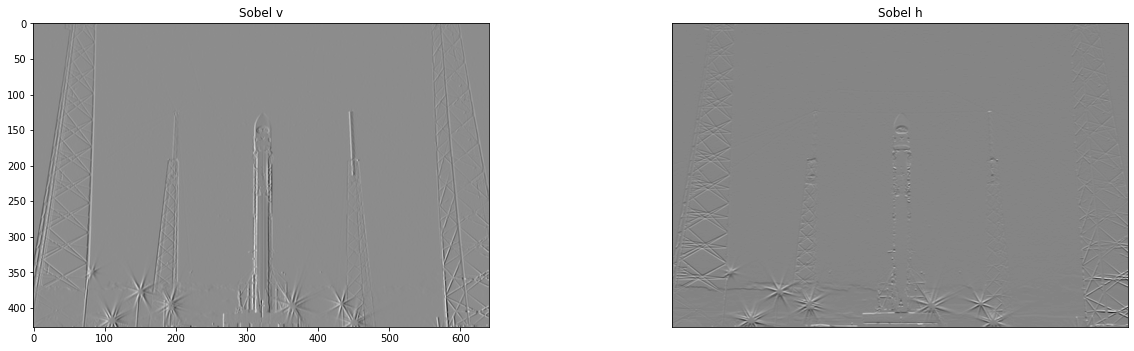

In [ ]:
from skimage.filters import sobel_h, sobel_v
from skimage.exposure import equalize_hist, rescale_intensity

imagem_color = data.rocket() 
img = rgb2gray(imagem_color)
print(img.shape)

#limiar = 160
#img[img > limiar] = 255
#img[img <= limiar] = 0

img_sobel_h = sobel_h(img)
img_sobel_v = sobel_v(img)

fig = plt.figure(figsize=(21, 19))
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(img_sobel_h,cmap = 'gray')
plt.title('Sobel h'), 
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(img_sobel_v,cmap = 'gray')
plt.title('Sobel v')

plt.show()

<h2>Exercício 2</h2>

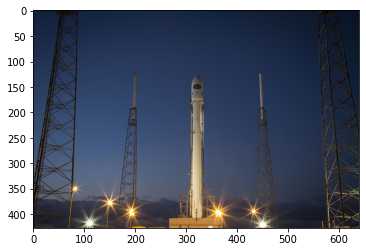

In [ ]:
from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter, correlate
from skimage import io
import numpy as np
import functools
%matplotlib inline

imgd = data.rocket()
plt.imshow(imgd)

In [ ]:
ws = [-1,-2,-1,0,0,0,1,2,1,]

# Um array de dimensao 5x5
kernel = np.ones((3,3),np.uint8)

# Uma máscara de 9 elementos
ws = [-1,-2,-1,0,0,0,1,2,1,]
# uma imagem 8x8 com 1's
imgd = np.ones((8,8),np.int8)
# acertando os valores
imgd[0,:] = [10, 9, 8, 25, 11, 12, 12, 11]
#img[0,7] = 0
imgd[1,:] = [9, 8, 11, 26, 11, 10, 11, 11]
imgd[2,:] = [11, 12, 9, 25, 12, 10, 11, 9]
imgd[3,:] = [10, 12, 11, 27, 12, 11, 10, 11]
imgd[4,:] = [9,  7,  8,  27,  8,  9,  9,  8]
imgd[5,:] = [11, 11, 10, 24, 12, 10, 11, 12]
imgd[6,:] = [9,  9,  8,  28,  9,  9,  9,  8]
imgd[7,:] = [9,  8,  9,  26,  8,  9,  9,  9]


# esta função 
def fncnaq(buffer,weights):
    #weights = [1,1,1,1,1,1,1,1,1]
    return (buffer * weights).sum()

def fncabs(buffer,weights):
    return min(abs((buffer * weights).sum()),255)


In [ ]:
generic_filter(imgd,function=fnc,footprint=kernel,extra_arguments=(ws,))

array([[0, 0, 6, 5, 0, 0, 0, 0],
       [6, 8, 5, 2, 0, 0, 0, 0],
       [7, 9, 5, 3, 4, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 2, 4],
       [2, 4, 3, 3, 3, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 3]], dtype=int8)

In [ ]:
generic_filter(imgd,function=fncnaq,footprint=kernel,extra_arguments=(ws,))

array([[ -4,   0,   6,   5,  -1,  -5,  -4,  -1],
       [  6,   8,   5,   2,   0,  -4,  -6,  -7],
       [  7,   9,   5,   3,   4,   2,  -1,  -1],
       [-11, -13,  -5,  -1,  -7,  -8,  -6,  -5],
       [  2,  -2,  -6,  -7,  -4,  -1,   2,   4],
       [  2,   4,   3,   3,   3,   1,   0,   0],
       [ -9,  -9,  -3,  -1,  -7,  -8,  -8, -11],
       [ -1,  -1,  -1,  -4,  -4,  -1,   1,   3]], dtype=int8)

In [ ]:
generic_filter(imgd,function=fncabs,footprint=kernel,extra_arguments=(ws,))

array([[ 4,  0,  6,  5,  1,  5,  4,  1],
       [ 6,  8,  5,  2,  0,  4,  6,  7],
       [ 7,  9,  5,  3,  4,  2,  1,  1],
       [11, 13,  5,  1,  7,  8,  6,  5],
       [ 2,  2,  6,  7,  4,  1,  2,  4],
       [ 2,  4,  3,  3,  3,  1,  0,  0],
       [ 9,  9,  3,  1,  7,  8,  8, 11],
       [ 1,  1,  1,  4,  4,  1,  1,  3]], dtype=int8)